Dicoding IDCamp 2024: Machine Learning Terapan

Model Sistem Rekomendasi

Nama: Nugroho Adi Wirapratama

Email: adiwira009@gmail.com

LinkedIn: https://www.linkedin.com/in/nug-adiwira/

Github: https://github.com/adiwira09

# Download dataset

In [ ]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("aprabowo/indonesia-tourism-destination")
shutil.move(path, '/content')

100%|██████████| 158k/158k [00:00<00:00, 9.54MB/s]

Extracting files...


'/content/1'

# Import library

In [ ]:
!pip install Sastrawi -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.26.4 -q

!pip install scikit-surprise==1.1.4 -q

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Restart kernel terlebih dahulu

In [ ]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.accuracy import rmse, mae

import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load data

In [ ]:
tourism = pd.read_csv('1/tourism_with_id.csv')
rating = pd.read_csv('1/tourism_rating.csv')

In [ ]:
print(f"Data tourism\nJumlah kolom: {tourism.shape[1]}\nJumlah baris: {tourism.shape[0]}\n")
print(f"Data Rating\nJumlah kolom: {rating.shape[1]}\nJumlah baris: {rating.shape[0]}")

Data tourism
Jumlah kolom: 13
Jumlah baris: 437

Data Rating
Jumlah kolom: 3
Jumlah baris: 10000


Dataset information:
1. tourism_ with _id.csv : berisi informasi tentang objek wisata di 5 kota besar di Indonesia dengan total sekitar 400 tempat wisata.
2. tourism_rating.csv : berisi 3 kolom, yaitu pengguna, tempat wisata, dan rating yang diberikan, digunakan untuk membuat sistem rekomendasi berdasarkan rating.

# Data understanding

In [ ]:
tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


**Kolom Information:**
- Place_Id : id dari Place_Name.
- Place_Name : nama tempat destinasi.
- Description : teks deskripsi tentang destinasi.
- Category : kategori dari destinasi.
- City : lokasi kota dari destinasi.
- Price : harga tiket masuk destinasi.
- Rating : rata-rata rating yang diberikan destinasi.
- Time_Minutes :
- Coordinate : Koordinat longitude & latitude destinasi.
- Lat : Koordinat latitude destinasi wisata.
- Long : Koordinat longitude destinasi wisata.
- Unnamed: 11 : Unknown information
- Unnamed: 12 : Unknown information

In [ ]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


**Kolom Information:**
- User_Id : user_id.
- Place_Id : id dari Place_Name.
- Place_Ratings : rating yang diberikan User_Id terhadap destinasi.

In [ ]:
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [ ]:
tourism.describe()

,Place_Id,Price,Rating,Time_Minutes,Lat,Long,Unnamed: 11,Unnamed: 12
count,437.000000,437.000000,437.000000,205.000000,437.000000,437.000000,0.0,437.000000
mean,219.000000,24652.173913,4.442792,82.609756,-7.095438,109.160142,NaN,219.000000
std,126.295289,66446.374709,0.208587,52.872339,0.727241,1.962848,NaN,126.295289
min,1.000000,0.000000,3.400000,10.000000,-8.197894,103.931398,NaN,1.000000
25%,110.000000,0.000000,4.300000,45.000000,-7.749590,107.578369,NaN,110.000000
50%,219.000000,5000.000000,4.500000,60.000000,-7.020524,110.237468,NaN,219.000000
75%,328.000000,20000.000000,4.600000,120.000000,-6.829411,110.431869,NaN,328.000000
max,437.000000,900000.000000,5.000000,360.000000,1.078880,112.821662,NaN,437.000000


In [ ]:
rating.describe()

,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


In [ ]:
tourism.isna().sum()

,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


In [ ]:
print(f'Jumlah data duplikat pada tourism_with_id.csv: {tourism.duplicated().sum()}')

Jumlah data duplikat pada tourism_with_id.csv: 0


Pada data tourism_with_id.csv:
- Tidak terdapat data duplikat.
- Terdapat NaN value pada kolom Time_Minutes dan Unnamed: 11

In [ ]:
rating.isna().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [ ]:
print(f'Jumlah data duplikat pada tourism_rating.csv: {rating.duplicated().sum()}')

Jumlah data duplikat pada tourism_rating.csv: 79


Pada data tourism_rating.csv:
- Terdapat 79 data duplikat yang benar-benar sama.
- Tidak ada data null.

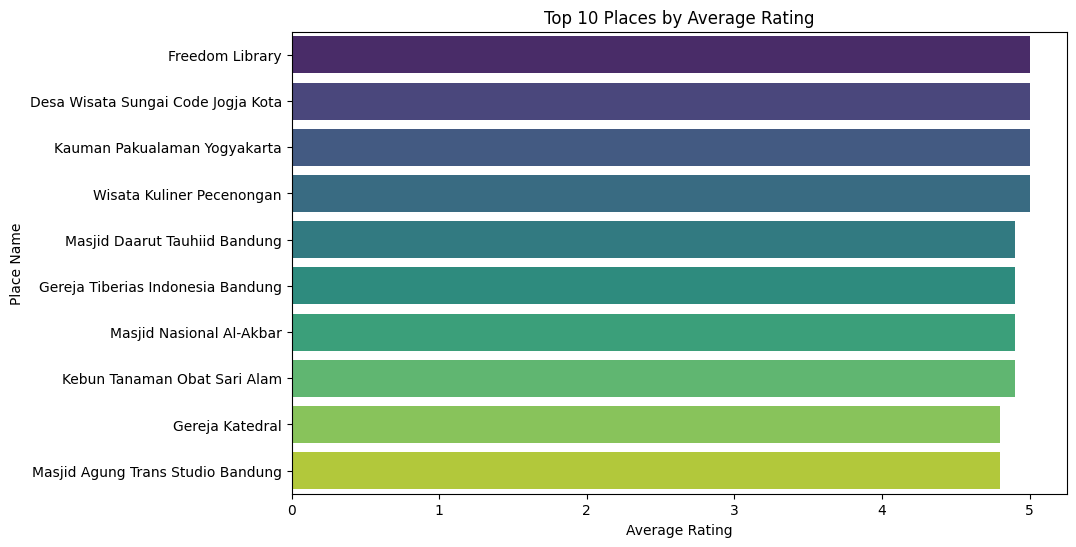

In [ ]:
top_10_places = tourism.sort_values(by='Rating', ascending=False).head(10)

# Visualizing with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_places['Rating'], y=top_10_places['Place_Name'], palette='viridis')
plt.title('Top 10 Places by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Place Name')
plt.show()

Freedom Library menduduki peringkat pertama dengan rating tertinggi, diikuti oleh Desa Wisata Sungai Code Jogja Kota dan Kauman Pakualaman Yogyakarta.

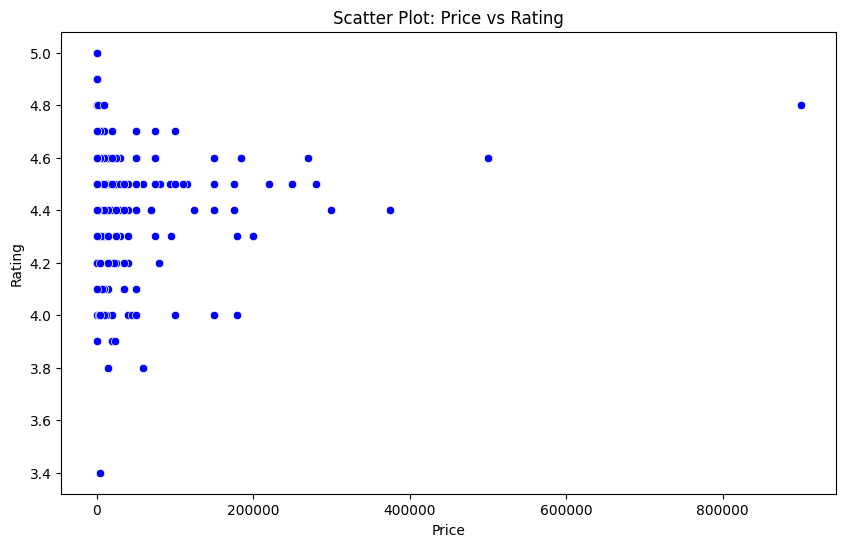

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tourism['Price'], y=tourism['Rating'], color='blue')
plt.title('Scatter Plot: Price vs Rating')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

Dari scatter plot, terlihat bahwa meskipun harga bervariasi, sebagian besar destinasi memiliki rating tinggi (di atas 4), namun tidak ada pola yang jelas antara harga dan rating.

In [ ]:
import statsmodels.api as sm

# Menambahkan konstanta untuk model regresi
X = sm.add_constant(tourism['Price'])
y = tourism['Rating']

# Membuat model regresi
model = sm.OLS(y, X).fit()

# Melihat hasil ringkasan model regresi
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2351
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.628
Time:                        12:02:54   Log-Likelihood:                 65.495
No. Observations:                 437   AIC:                            -127.0
Df Residuals:                     435   BIC:                            -118.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4410      0.011    416.857      0.0

Dalam analisis regresi, hasil menunjukkan bahwa koefisien untuk harga sangat kecil (7.296e-08), dan p-value sebesar 0.628 menunjukkan bahwa harga tidak berpengaruh signifikan terhadap rating destinasi wisata. Nilai R-squared yang sangat rendah (0.001) juga menegaskan bahwa harga hanya menjelaskan sedikit sekali variasi dalam rating.

**Harga tidak menjadi faktor yang signifikan dalam menentukan rating destinasi wisata.**

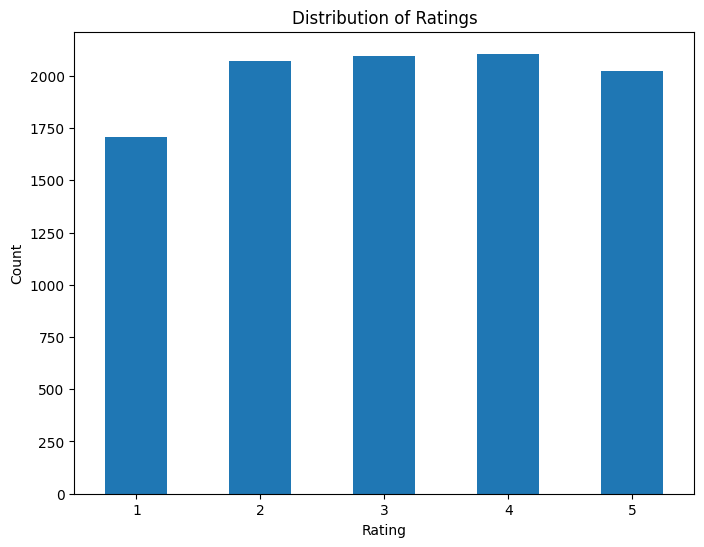

In [ ]:
rating_distribution = rating['Place_Ratings']
rating_counts = pd.Series(rating_distribution).value_counts().sort_index()

plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Dari grafik ini, dapat dilihat bahwa distribusi pemberian rating oleh user relatif merata, di mana setiap rating (1 hingga 5) memiliki jumlah yang hampir sama, sekitar 2000, dengan sedikit perbedaan antara setiap kategori rating.

# Data preparation

## Merge Dataset

In [ ]:
# Merge dataset
df_merge = pd.merge(rating, tourism, on='Place_Id', how='left')

## Menghapus kolom tidak relevan

In [ ]:
df_clean = df_merge.drop(['Unnamed: 11','Unnamed: 12', 'Time_Minutes', 'Coordinate',	'Lat',	'Long', 'Rating', 'Price'], axis=1)

- Menghapus kolom yang tidak relevan untuk pembuatan model sistem rekomendasi.
- Pada Rating menggunakan kolom Place_Ratings dari dataset tourism_rating.csv karena menggambarkan interaksi user dalam memberikan rating terhadap destinasi.

## NaN value

In [ ]:
# cek missing value
df_clean.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0
Place_Name,0
Description,0
Category,0
City,0


Pada data understanding terdapat NaN value, tetapi terdapat pada kolom Time_Minutes dan Unnamed: 11 sehingga data tersebut tidak digunakan dan menjadi tidak ada NaN value

## Drop/delete duplikat value

In [ ]:
df_clean = df_clean.drop_duplicates()

## Processing text

In [ ]:
stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

In [ ]:
def preprocess(text):
    text = text.lower()                                  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)                  # Remove punctuation
    text = re.sub(r'\d+', '', text)                      # Remove numbers (optional)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    text = ' '.join(tokens)
    text = stemmer.stem(text)                            # Stemming
    return text

In [ ]:
df_clean['Description'] = df_clean['Description'].apply(preprocess)
df_clean['City'] = df_clean['City'].apply(preprocess)
df_clean['Category'] = df_clean['Category'].apply(preprocess)

In [ ]:
df_clean.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City
0,1,179,3,Candi Ratu Boko,situs ratu baka candi boko hanacaraka bahasa j...,budaya,yogyakarta
1,1,344,2,Pantai Marina,pantai marina bahasa jawa translit pasisir mar...,bahari,semarang
2,1,5,5,Atlantis Water Adventure,atlantis water adventure kenal atlantis ancol ...,taman hibur,jakarta
3,1,373,3,Museum Kereta Ambarawa,museum kereta api ambarawa bahasa inggris indo...,budaya,semarang
4,1,101,4,Kampung Wisata Sosro Menduran,kampung wisata sosromenduran kampung wisata un...,budaya,yogyakarta


In [ ]:
print("Setelah dilakukan data preparation")

baris, kolom = df_clean.shape
print(f"Jumlah baris: {baris}")
print(f"Jumlah kolom: {kolom}")

Setelah dilakukan data preparation
Jumlah baris: 9921
Jumlah kolom: 7


## Pemisahan data (CBF dan CF)

### CBF

In [ ]:
df_cbf = df_clean.copy()
df_cbf.drop_duplicates(subset='Place_Id', inplace=True)
df_cbf.drop(['User_Id', 'Place_Ratings'], axis=1, inplace=True)
df_cbf.reset_index(drop=True, inplace=True)
df_cbf

,Place_Id,Place_Name,Description,Category,City
0,179,Candi Ratu Boko,situs ratu baka candi boko hanacaraka bahasa j...,budaya,yogyakarta
1,344,Pantai Marina,pantai marina bahasa jawa translit pasisir mar...,bahari,semarang
2,5,Atlantis Water Adventure,atlantis water adventure kenal atlantis ancol ...,taman hibur,jakarta
3,373,Museum Kereta Ambarawa,museum kereta api ambarawa bahasa inggris indo...,budaya,semarang
4,101,Kampung Wisata Sosro Menduran,kampung wisata sosromenduran kampung wisata un...,budaya,yogyakarta
...,...,...,...,...,...
432,370,Benteng Pendem,benteng pendem cilacap bahasa belanda kustbatt...,budaya,semarang
433,350,Pantai Cipta,pantai cipta kenal pantai petikemas jarak leta...,bahari,semarang
434,10,Pulau Tidung,pulau tidung salah lurah camat pulau ribu sela...,bahari,jakarta
435,7,Kebun Binatang Ragunan,kebun binatang ragunan kebun binatang letak da...,cagar alam,jakarta


In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_cbf['Description'])

print(tfidf_matrix.shape)

(437, 4724)


In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.06215763, 0.00473724, ..., 0.02041706, 0.01608572,
        0.        ],
       [0.06215763, 1.        , 0.00801715, ..., 0.02297934, 0.00700927,
        0.01489439],
       [0.00473724, 0.00801715, 1.        , ..., 0.01118615, 0.00971604,
        0.03277783],
       ...,
       [0.02041706, 0.02297934, 0.01118615, ..., 1.        , 0.02991857,
        0.        ],
       [0.01608572, 0.00700927, 0.00971604, ..., 0.02991857, 1.        ,
        0.        ],
       [0.        , 0.01489439, 0.03277783, ..., 0.        , 0.        ,
        1.        ]])

### CF

In [ ]:
df_cf = df_clean.copy()
df_cf.drop(['Place_Id', 'Description', 'City', 'Category'], axis=1, inplace=True)

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_cf[['User_Id', 'Place_Name', 'Place_Ratings']], reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Model development

## CBF

In [ ]:
def get_recommendations(query_index, n_recommendations=5):
    place_name = df_cbf['Place_Name'][query_index]
    category = df_cbf['Category'][query_index]
    city = df_cbf['City'][query_index]
    description = df_cbf['Description'][query_index]

    # Tampilkan info awal
    print(f'Destinasi: {place_name}')
    print(f'Kategori: {category}')
    print(f'Kota: {city}')
    print(f'Deskripsi: {description}\n')
    print(f'{n_recommendations} Rekomendasi:\n')

    similarity_scores = list(enumerate(cosine_sim[query_index]))

    recommendations = []
    for idx, sim_score in similarity_scores:
        if idx == query_index:
            continue  # skip diri sendiri

        # Binary match: 1 jika sama, 0 jika tidak
        category_score = 1 if df_cbf['Category'][idx] == category else 0
        city_score = 1 if df_cbf['City'][idx] == city else 0
        description_score = sim_score

        # Hitung total skor akhir
        final_score = (0.6 * description_score) + (0.25 * category_score) + (0.15 * city_score)

        recommendations.append({
            'Recommended Destination': df_cbf['Place_Name'][idx],
            'Category': df_cbf['Category'][idx],
            'City': df_cbf['City'][idx],
            'Description Similarity': round(description_score, 4),
            'Category Score': round(category_score, 4),
            'City Score': round(city_score, 4),
            'Total Score': round(final_score, 4)
        })

    # Buat DataFrame dari hasil rekomendasi dan ambil n teratas
    recommendations_df = pd.DataFrame(recommendations).sort_values(by='Total Score', ascending=False)
    return recommendations_df.head(n_recommendations)

In [ ]:
query_index = 21
recommendations = get_recommendations(query_index, n_recommendations=10)
recommendations

Destinasi: Pasar Seni
Kategori: pusat belanja
Kota: jakarta
Deskripsi: pasar seni pusat rajin seni wadah seniman bakat salur rajin seni milik seniman temu kolektor seni usaha bagi informasi pasar produk milik diri leta batu bang ali sadikin gubernur dki jakarta tepat juli resmi gubernur h tjokropanolo tanggal desember resmi pasar seni sambut positif cinta seni

10 Rekomendasi:



,Recommended Destination,Category,City,Description Similarity,Category Score,City Score,Total Score
167,Pasar Tanah Abang,pusat belanja,jakarta,0.2060,1,1,0.5236
307,Pasar Taman Puring,pusat belanja,jakarta,0.1362,1,1,0.4817
316,Mall Thamrin City,pusat belanja,jakarta,0.0530,1,1,0.4318
292,Plaza Indonesia,pusat belanja,jakarta,0.0525,1,1,0.4315
273,Pecinan Glodok,pusat belanja,jakarta,0.0429,1,1,0.4257
106,Pasar Petak Sembilan,pusat belanja,jakarta,0.0317,1,1,0.4190
304,Kawasan Kuliner BSM,pusat belanja,jakarta,0.0216,1,1,0.4130
339,Wisata Kuliner Pecenongan,pusat belanja,jakarta,0.0147,1,1,0.4088
205,Pasar Baru,pusat belanja,bandung,0.2566,1,0,0.4040
209,Grand Indonesia Mall,pusat belanja,jakarta,0.0065,1,1,0.4039


precision@10 (Category) = 10/10 = 1.0

precision@10 (Kota) = 9/10 = 0.9

precision@10 (Category & Kota) = 9/10 = 0.9

Terlihat bahwa hampir seluruh hasil memiliki kategori yang sama (pusat belanja) dan berada di lokasi yang sama (Jakarta), dengan deskripsi yang mengandung kesamaan tematik seperti “pasar”, “belanja”, “kawasan seni”, dan “kolektor”.

## CF

In [ ]:
# Gunakan SVD untuk matrix factorization
model = SVD()
model.fit(trainset)

predictions = model.test(testset)

In [ ]:
# Fungsi rekomendasi berdasarkan matrix factorization
def get_mf_recommendations(user_id, top_n=5):
    place_names = df_cf['Place_Name'].unique()
    rated_places = df_cf[df_cf['User_Id'] == user_id]['Place_Name'].tolist()
    unrated_places = [place for place in place_names if place not in rated_places]

    pred_ratings = []
    for place in unrated_places:
        pred = model.predict(user_id, place)
        pred_ratings.append((place, pred.est))

    sorted_preds = sorted(pred_ratings, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(sorted_preds, columns=['Recommended Place', 'Predicted Rating'])

# Contoh pemanggilan
get_mf_recommendations(user_id=1, top_n=10)

,Recommended Place,Predicted Rating
0,Kampung Wisata Taman Sari,4.086303
1,Glamping Lakeside Rancabali,4.021376
2,Teras Cikapundung BBWS,4.017713
3,Taman Hiburan Rakyat,3.992269
4,Air Terjun Kedung Pedut,3.977583
5,Keraton Surabaya,3.941486
6,Alun-Alun Kota Bandung,3.924178
7,Candi Ijo,3.914616
8,Taman Pelangi,3.898847
9,Bukit Wisata Pulepayung,3.875808


In [ ]:
# Evaluasi: RMSE dan MAE
rmse(predictions)
mae(predictions)

RMSE: 1.4485
MAE:  1.2475


1.2474883114423205

Model untuk sistem rekomendasi Coolaborative Filtering menggunakan algoritma Singular Value Decomposition (SVD) mendapatkan skor evaluasi
- RMSE : 1.4485
- MAE : 1.22475